# Introduction

Early stopping is a regularization technique that can be used in iterative optimization algorithms such as gradient descent, to prevent overfitting and to find the optimal stopping point during training. Early stopping avoids overfitting by stopping the training process before the model starts to memorize the training data too closely. It helps to find a balance between underfitting and overfitting, leading to better generalization performance on unseen data.

Steps:

- Monitoring Performance: During the training process, the performance of the model is monitored on a separate validation dataset (or a portion of the training data held out for validation).

- Stopping Criteria: Early stopping defines a criteria, typically based on the performance metric (like accuracy, loss, etc.), that indicates when to stop the training process.

- Validation Set Performance: At each iteration or after a certain number of iterations, the performance metric on the validation set is evaluated.

- Stopping Decision: If the performance metric on the validation set stops improving or starts deteriorating, early stopping is triggered. This suggests that the model might be overfitting the training data or that further training isn't improving generalization.

- Stopping Training: When early stopping is triggered, the training process is halted, and the model parameters from the point at which the performance was the best are typically retained.

This notebook demonstrates the use of Ealy Stopping when training XGBoost classifiers on a dataset, along with the visualization of the model's performance using loss curves (log loss and classification error) over training epochs.

In [1]:
#!pip install xgboost

In [2]:
import numpy as np #python library for working with arrays
import pandas as pd # for working with datasets

#Graphs
import matplotlib.pyplot as plt #visualization
from matplotlib import pyplot #visualization 
%matplotlib inline 
#static images of your plot embedded in the workbook

#For splitting the train and test data
from sklearn.model_selection import train_test_split

#For Sampling
from sklearn.utils import resample

#XGBoost Algorithm
import xgboost as xgb

#Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

# from numpy import loadtxt
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('../data/aug_train.csv')
data.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0
5,295775,Female,25,1,25.0,1,< 1 Year,No,27954.0,152.0,23,0
6,71711,Male,51,1,8.0,0,1-2 Year,Yes,2630.0,26.0,209,0
7,331781,Male,38,1,28.0,1,1-2 Year,No,2630.0,26.0,51,0
8,290704,Female,45,1,28.0,0,1-2 Year,Yes,55873.0,124.0,262,0
9,344792,Male,42,1,28.0,0,1-2 Year,Yes,27801.0,122.0,217,1


## Basic Data Exploration and Preprocessing

In [4]:
data.isnull().sum().sum() #checking for null values

0

In [5]:
# One-hot-encoding for categorical columns
data = pd.get_dummies(data, ['Gender', 'Vehicle_Age', 'Vehicle_Damage'], drop_first=True) 

In [6]:
data

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,167647,22,1,7.0,1,2630.0,152.0,16,0,True,True,False,False
1,17163,42,1,28.0,0,43327.0,26.0,135,0,True,False,False,True
2,32023,66,1,33.0,0,35841.0,124.0,253,0,False,False,False,True
3,87447,22,1,33.0,0,27645.0,152.0,69,0,False,True,False,False
4,501933,28,1,46.0,1,29023.0,152.0,211,0,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
382149,164549,24,1,15.0,0,23938.0,152.0,105,0,True,True,False,True
382150,247064,27,1,28.0,1,336395.0,152.0,144,0,True,True,False,False
382151,165293,45,1,28.0,0,40443.0,26.0,187,0,True,False,False,True
382152,383241,28,1,28.0,1,25380.0,152.0,208,0,False,True,False,False


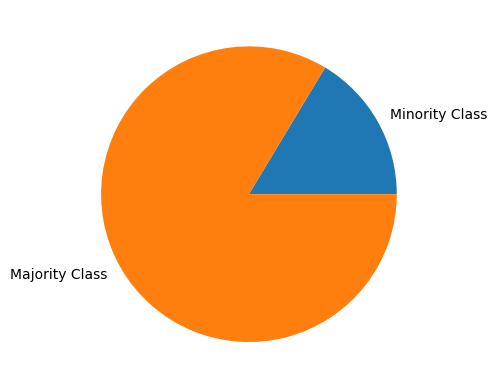

In [7]:
class_division = [ data[data['Response'] == 1 ].shape[0], data[data['Response'] == 0 ].shape[0] ]
my_labels = ['Minority Class', 'Majority Class']

plt.pie(class_division, labels = my_labels)
plt.show()

In [8]:
print("Proportion of Minority Class: " + str(round(data[data['Response'] == 1 ].shape[0]/data.shape[0] * 100, 2)) + "%")

Proportion of Minority Class: 16.38%


In [9]:
def evaluate_model(y_test, y_pred, header):
    # make predictions for test data
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(conf_matrix, cmap=plt.cm.Accent, alpha=0.4)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=10)
    plt.ylabel('Actuals', fontsize=10)
    plt.title('Confusion Matrix', fontsize=15)
    plt.show()

    precision =  round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    F1 =  round(f1_score(y_test, y_pred), 4)
    metrics = [precision, recall, F1]

    results = pd.DataFrame(metrics)
    results.index = ['Precision', 'Recall', 'F1_score']
    results.columns = [header]
    results

## Split the dataset (train/val/test)

In [10]:
X = data.drop(columns= ['id', 'Response']) #Columns to be excluded from training set
y = data['Response'] #defining the Response as y

X.columns = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage',
       'Gender_Male', 'Vehicle_Age_lessthan_1_Year',
       'Vehicle_Age_greaterthan_2_Years', 'Vehicle_Damage_Yes']

In [11]:

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7, stratify=y_train)

# XGBoostClassifier without Early Stopping

In [32]:
xgb_without_early_stopping = xgb.XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.1)
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_without_early_stopping.fit(X_train, y_train, eval_metric=["auc", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.87890	validation_0-logloss:0.63496	validation_1-auc:0.87665	validation_1-logloss:0.63507
[1]	validation_0-auc:0.88463	validation_0-logloss:0.58710	validation_1-auc:0.88248	validation_1-logloss:0.58727
[2]	validation_0-auc:0.88525	validation_0-logloss:0.54741	validation_1-auc:0.88363	validation_1-logloss:0.54765
[3]	validation_0-auc:0.88609	validation_0-logloss:0.51382	validation_1-auc:0.88447	validation_1-logloss:0.51410
[4]	validation_0-auc:0.88615	validation_0-logloss:0.48515	validation_1-auc:0.88451	validation_1-logloss:0.48548
[5]	validation_0-auc:0.88610	validation_0-logloss:0.46059	validation_1-auc:0.88452	validation_1-logloss:0.46098
[6]	validation_0-auc:0.88628	validation_0-logloss:0.43946	validation_1-auc:0.88457	validation_1-logloss:0.43994
[7]	validation_0-auc:0.88628	validation_0-logloss:0.42104	validation_1-auc:0.88426	validation_1-logloss:0.42159
[8]	validation_0-auc:0.88822	validation_0-logloss:0.40466	validation_1-auc:0.88617	validation_1-logloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

              precision    recall  f1-score   support

     class 0       0.89      0.93      0.91     63911
     class 1       0.53      0.40      0.46     12520

    accuracy                           0.84     76431
   macro avg       0.71      0.67      0.68     76431
weighted avg       0.83      0.84      0.84     76431



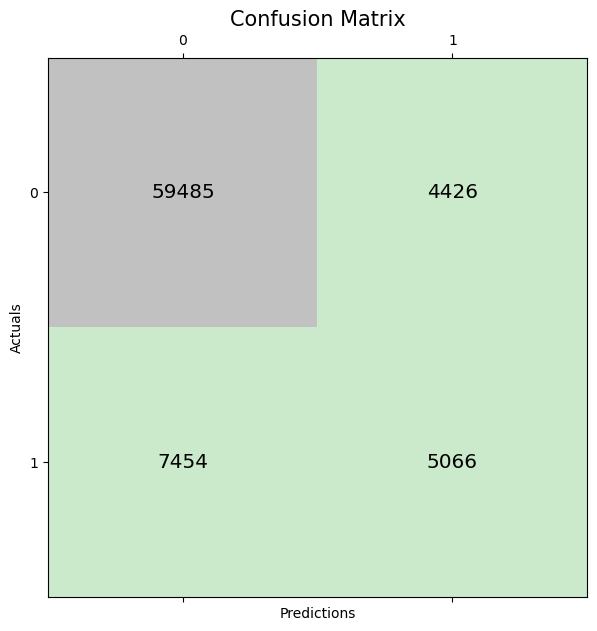

In [33]:
y_pred = xgb_without_early_stopping.predict(X_test)
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names = target_names))
evaluate_model(y_test, y_pred, 'Without Early Stopping')

In [24]:
def plot_loss_curves(model, metric):
    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0'][metric])
    x_axis = range(0, epochs)

    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Val')
    ax.legend()
    pyplot.xlabel('Epochs')
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()

    # plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0'][metric], label='Train')
    ax.plot(x_axis, results['validation_1'][metric], label='Val')
    ax.legend()
    pyplot.ylabel(f'Metric: {metric}')
    pyplot.title(f'{metric}')
    pyplot.show()

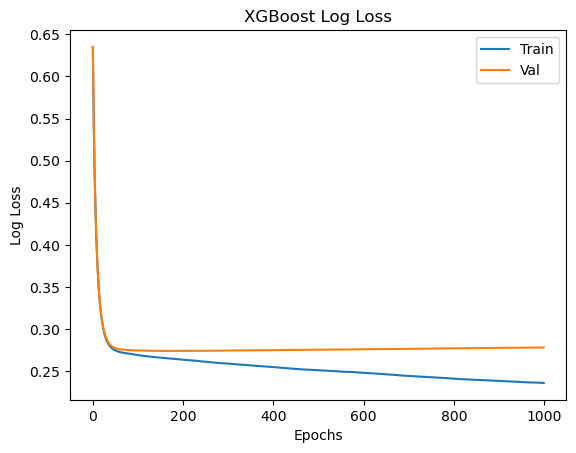

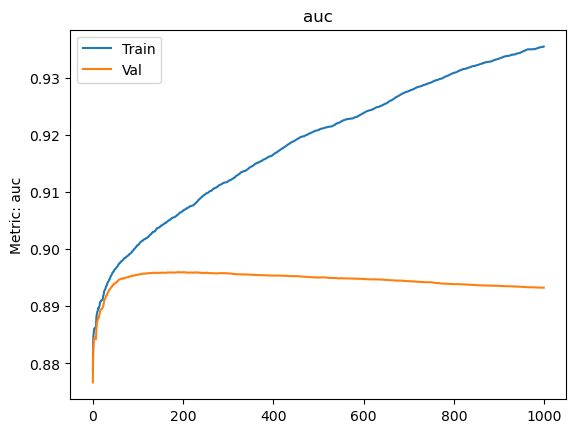

In [34]:
plot_loss_curves(xgb_without_early_stopping, 'auc')

# XGBoostClassifier with Early Stopping

When XGBoost is training successive decision trees to reduce error on the training set, it’s possible that adding more and more trees to the ensemble will provide increasingly better fits to the training data, but start to cause lower performance on held-out data. To avoid this, we can use a validation set, also called an **evaluation set** or ``eval_set`` by XGBoost. The evaluation set will be supplied as a list of tuples of features and their corresponding response variables. Whichever tuple comes last in this list will be the one that is used for early stopping. We want this to be the validation set because the training data will be used to fit the model and can’t provide an estimate of out-of-sample generalization:

> eval_set = [(X_train, y_train), (X_val, y_val)]

Now we can fit the model again, but this time we supply the eval_set keyword argument with the evaluation set we just created. At this point, the eval_metric of auc becomes important. This means that after each boosting round, before training another decision tree, the area under the ROC curve will be evaluated on all the datasets supplied with eval_set. Because we’ll indicate verbosity=True, we’ll get output printed below the cell with the ROC AUC for both the training set and the validation set. This provides a nice live look at how model performance changes on the training and validation data as more boosting rounds are trained.

In [35]:
# fit model on training data
xgb_with_early_stopping = XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.1, early_stopping_rounds=20)
eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_with_early_stopping.fit(X_train, y_train, eval_metric=["auc", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.87890	validation_0-logloss:0.63496	validation_1-auc:0.87665	validation_1-logloss:0.63507
[1]	validation_0-auc:0.88463	validation_0-logloss:0.58710	validation_1-auc:0.88248	validation_1-logloss:0.58727
[2]	validation_0-auc:0.88525	validation_0-logloss:0.54741	validation_1-auc:0.88363	validation_1-logloss:0.54765
[3]	validation_0-auc:0.88609	validation_0-logloss:0.51382	validation_1-auc:0.88447	validation_1-logloss:0.51410
[4]	validation_0-auc:0.88615	validation_0-logloss:0.48515	validation_1-auc:0.88451	validation_1-logloss:0.48548
[5]	validation_0-auc:0.88610	validation_0-logloss:0.46059	validation_1-auc:0.88452	validation_1-logloss:0.46098
[6]	validation_0-auc:0.88628	validation_0-logloss:0.43946	validation_1-auc:0.88457	validation_1-logloss:0.43994
[7]	validation_0-auc:0.88628	validation_0-logloss:0.42104	validation_1-auc:0.88426	validation_1-logloss:0.42159
[8]	validation_0-auc:0.88822	validation_0-logloss:0.40466	validation_1-auc:0.88617	validation_1-logloss:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

The loss values can be retrieved from the model with `evals_result()` and plotted for diagnosis.

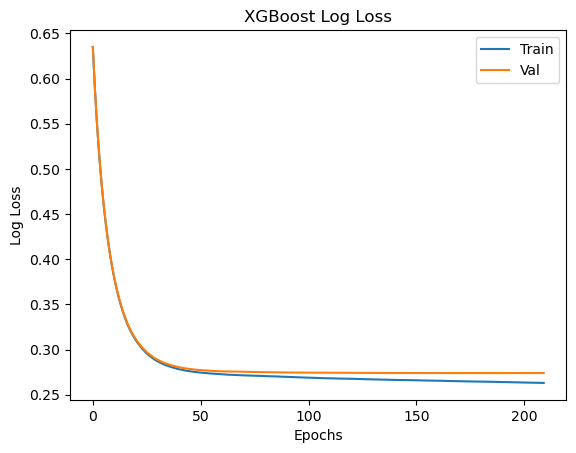

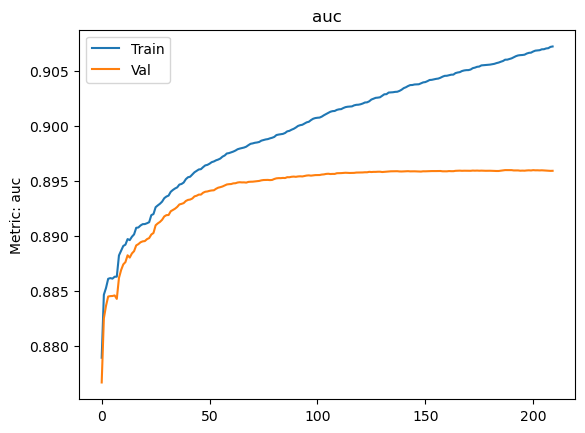

In [36]:
plot_loss_curves(xgb_with_early_stopping, 'auc')

              precision    recall  f1-score   support

     class 0       0.89      0.94      0.91     63911
     class 1       0.55      0.39      0.46     12520

    accuracy                           0.85     76431
   macro avg       0.72      0.66      0.68     76431
weighted avg       0.83      0.85      0.84     76431



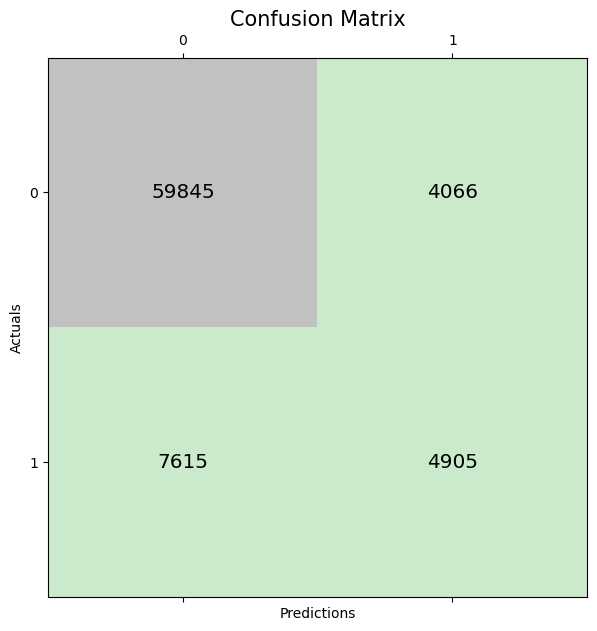

In [37]:
target_names = ['class 0', 'class 1']
# make predictions for test data
y_pred = xgb_with_early_stopping.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))
evaluate_model(y_test, y_pred, 'With Early Stopping')

In [38]:
xgb_with_early_stopping.best_iteration

189

In [39]:
xgb_with_early_stopping.best_ntree_limit

190

In [42]:
y_pred[:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0])

              precision    recall  f1-score   support

     class 0       0.89      0.94      0.91     63911
     class 1       0.55      0.39      0.46     12520

    accuracy                           0.85     76431
   macro avg       0.72      0.66      0.68     76431
weighted avg       0.83      0.85      0.84     76431



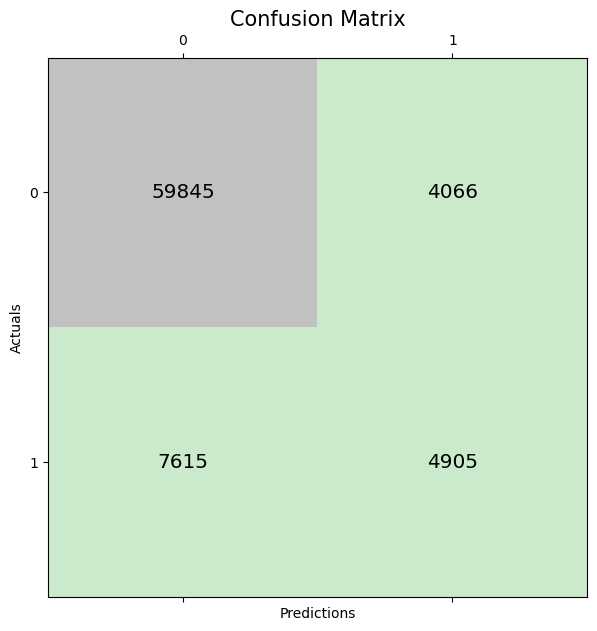

In [43]:
y_pred = xgb_with_early_stopping.predict(X_test, ntree_limit=xgb_with_early_stopping.best_ntree_limit)
# y_pred = xgb_with_early_stopping.predict(X_test, iteration_range=(0, xgb_with_early_stopping.best_iteration+1))

target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))
evaluate_model(y_test, y_pred, 'With Early Stopping')

# References

1. [Early Stopping. The Most Popular Regularization Technique In Machine Learning.](https://youtu.be/CODw8292uqE)